# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# Evaluate logits

In [5]:
MODEL_ARC = 'efficientnetv2_xl' #wide_resnet50_2, vgg16
DATASET = 'ImageNet'

In [6]:
VAL_SIZE = 0.1 #5000
logits_val,labels_val,logits_test,labels_test = split_data.split_logits(*upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev),VAL_SIZE,SEED)
risk_val = measures.wrong_class(logits_val,labels_val).float()
risk_test = measures.wrong_class(logits_test,labels_test).float()

In [7]:
METRIC = metrics.AURC

# Optimization and RC

In [8]:
T_nll = post_hoc.optimize.T(logits_val,labels_val,metric = torch.nn.CrossEntropyLoss(),method = lambda x: x)
T = post_hoc.optimize.T(logits_val,risk_val,metric =  METRIC)
p = post_hoc.optimize.p(logits_val,risk_val, method = measures.max_logit,metric= METRIC,MSP_fallback=False)
pT = post_hoc.optimize.p_and_T(logits_val,risk_val,method = measures.MSP,metric = METRIC)

In [9]:
methods = {'MSP': measures.MSP(logits_test),
           'MSP-TS-NLL': measures.MSP(logits_test.div(T_nll)),
           'MSP-TS-AURC': measures.MSP(logits_test.div(T)),
           'MSP-pNorm': measures.MSP(post_hoc.normalize(logits_test,pT[0]).div(pT[1])),
           'MaxLogit-pNorm': post_hoc.MaxLogit_pNorm(logits_test,p),
           'Optimal RC': 1-risk_test}


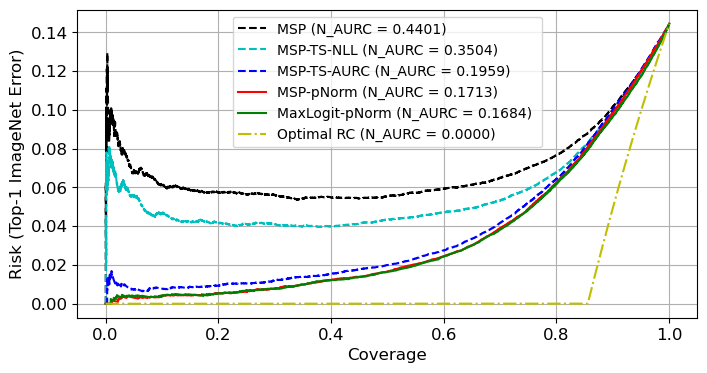

In [11]:
fig = plt.figure(figsize = (8,4))
fig.tight_layout()

linestyle = {'MSP': 'k--',
           'MSP-TS-NLL': 'c--',
           'MSP-TS-AURC': 'b--',
           'MSP-pNorm': 'red',
           'MaxLogit-pNorm': 'green',
           'Optimal RC': 'y-.'
            }

for n,m in methods.items():
    plt.plot(*metrics.RC_curve(m,risk_test),linestyle[n],
              label  = n+ f' (N_AURC = {metrics.N_AURC(m,risk_test):.4f}) ')

plt.grid()
plt.legend()
plt.xlabel('Coverage',fontsize = 12)
plt.ylabel(f'Risk (Top-1 {DATASET} Error)',fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(FIGS_PATH, f'RC-{MODEL_ARC}-{DATASET}.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show()